1  Подготовка данных:
 - 1.1  Открою файлы и изучите их
 - 1.2  Проверю, что эффективность обогащения рассчитана правильно.
 - 1.3  Преобразование данных
 - 1.4  Проанализирую признаки, недоступные в тестовой выборке

2  Анализ данных:
 - 2.1  Концентрация металлов
 - 2.2  Размер гранул
 - 2.3  Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
 - 2.4  Корреляция признаков

3  Модель:
 - 3.1  Признаки и целевые признаки
 - 3.2  Метрика качества
 - 3.3  Выбор модели. Флотация
   - 3.3.1  Линейная регрессия
   - 3.3.2  Решающее дерево
   - 3.3.3  Случайный лес
 - 3.4  Выбор модели. Очистка
   - 3.4.1  Линейная регрессия
   - 3.4.2  Решающее дерево
   - 3.4.3  Случайный лес
 - 3.5  Тестирование модели
 - 3.6  Адекватность модели
 - 3.7  Важность признаков

4  Выводы

# Восстановление золота из руды

Анализ данных и прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

### Открою файлы и изучите их

In [2]:
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer
from sklearn.pipeline import  make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from scipy import stats as st
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

C:\Users\Professional\anaconda3\envs\praktikum_env_win_new\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Описание данных

Технологический процесс

Rougher feed — исходное сырье

Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

Xanthate **— ксантогенат (промотер, или активатор флотации);

Sulphate — сульфат (на данном производстве сульфид натрия);

Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация

Rougher tails — отвальные хвосты

Float banks — флотационная установка

Cleaner process — очистка

Rougher Au — черновой концентрат золота

Final Au — финальный концентрат золота

Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

Наименование признаков

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Возможные значения для блока [тип_параметра]:

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики

In [3]:
def try_read(name):
    try:
         return pd.read_csv('C:/Users/Professional/praktikum/jupyter/сборный_проект_2/'+name) 
    except:
         return pd.read_csv('/datasets/'+name)

train = try_read('gold_recovery_train_new.csv')
test = try_read('gold_recovery_test_new.csv')
full = try_read('gold_recovery_full_new.csv')

In [4]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  \
0              0.895447              16.904297              2.143149   
1              0.927452              16.634514              2.224930   
2              0.953716              16.208849              2.257889   
3              0.883763              16.532835              2.146849   
4              0.792826              16.525686              2.055292   

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     127.092003                         10.128295   
1                     125.629232                         10.296251   
2                     123.819808                         11.316280   
3                     122.270188                         11.322140   
4                     117.988169                         11.913613   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                             7.25                        0.988759   
1                             7.25                        1.002663   
2                             7.25                        0.991265   
3                             7.25                        0.996739   
4                             7.25                        1.009869   

   primary_cleaner.output.concentrate_ag  \
0                               8.547551   
1                               8.558743   
2                               8.603505   
3                               7.221879   
4                               9.089428   

   primary_cleaner.output.concentrate_pb  \
0                              10.389648   
1                              10.497069   
2                              10.354494   
3                               8.496563   
4                               9.986786   

   primary_cleaner.output.concentrate_sol  \
0                               19.529297   
1                               19.369147   
2                               19.167579   
3                               15.978538   
4                               19.199864   

   primary_cleaner.output.concentrate_au  primary_cleaner.output.tail_ag  \
0                              34.174427                       14.936526   
1                              34.118526                       16.250511   
2                              33.969464                       16.491823   
3                              28.260743                       16.024359   
4                              33.044932                       16.480185   

   primary_cleaner.output.tail_pb  primary_cleaner.output.tail_sol  \
0                        2.534912                         7.476074   
1                        3.049646                         6.733907   
2                        3.124664                         6.471768   
3             

In [5]:
test.info()
test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  \
0                             1400.102998   
1                             1396.151033   
2                             1398.075709   
3                             1400.129303   
4                             1402.172226   

   primary_cleaner.state.floatbank8_c_level  \
0                               -500.704369   
1                               -499.240168   
2                               -502.151509   
3                               -498.355873   
4                               -500.810606   

   primary_cleaner.state.floatbank8_d_air  \
0                             1399.001695   
1                             1399.508091   
2                             1399.497088   
3                             1401.065165   
4                             1399.480508   

   primary_cleaner.state.floatbank8_d_level  rougher.input.feed_ag  \
0                               -499.485144              13.128569   
1                               -500.416324              13.036280   
2                               -499.715479              13.138412   
3                               -501.038738              12.400507   
4                               -499.374053              11.327427   

   rougher.input.feed_pb  rougher.input.feed_rate  rougher.input.feed_size  \
0               5.636710               489.793655                62.710452   
1               5.526065               490.104534                61.961163   
2               5.426561               489.617969                66.903807   
3               5.114758               476.618130                59.865919   
4               4.767383               488.248117                63.315324   

   rougher.input.feed_sol  rougher.input.feed_au  \
0               42.022440              12.084103   
1               41.187903              11.918977   
2               42.546294              12.091332   
3               41.

In [6]:
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  \
0              0.895447              16.904297              2.143149   
1              0.927452              16.634514              2.224930   
2              0.953716              16.208849              2.257889   
3              0.883763              16.532835              2.146849   
4              0.792826              16.525686              2.055292   

   primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
0                     127.092003                         10.128295   
1                     125.629232                         10.296251   
2                     123.819808                         11.316280   
3                     122.270188                         11.322140   
4                     117.988169                         11.913613   

   primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
0                             7.25                        0.988759   
1                             7.25                        1.002663   
2                             7.25                        0.991265   
3                             7.25                        0.996739   
4                             7.25                        1.009869   

   primary_cleaner.output.concentrate_ag  \
0                               8.547551   
1                               8.558743   
2                               8.603505   
3                               7.221879   
4                               9.089428   

   primary_cleaner.output.concentrate_pb  \
0                              10.389648   
1                              10.497069   
2                              10.354494   
3                               8.496563   
4                               9.986786   

   primary_cleaner.output.concentrate_sol  \
0                               19.529297   
1                               19.369147   
2                               19.167579   
3                               15.978538   
4                               19.199864   

   primary_cleaner.output.concentrate_au  primary_cleaner.output.tail_ag  \
0                              34.174427                       14.936526   
1                              34.118526                       16.250511   
2                              33.969464                       16.491823   
3                              28.260743                       16.024359   
4                              33.044932                       16.480185   

   primary_cleaner.output.tail_pb  primary_cleaner.output.tail_sol  \
0                        2.534912                         7.476074   
1                        3.049646                         6.733907   
2                        3.124664                         6.471768   
3             

In [7]:

print('Количество пропусков в каждом столбце, в процентах:')    
print(full.isna().mean() * 100)

Количество пропусков в каждом столбце, в процентах:
date                                                  0.000000
final.output.concentrate_ag                           0.005144
final.output.concentrate_pb                           0.005144
final.output.concentrate_sol                          1.085447
final.output.concentrate_au                           0.000000
final.output.recovery                                 0.000000
final.output.tail_ag                                  0.005144
final.output.tail_pb                                  0.519574
final.output.tail_sol                                 0.030866
final.output.tail_au                                  0.000000
primary_cleaner.input.sulfate                         0.123463
primary_cleaner.input.depressant                      0.190339
primary_cleaner.input.feed_size                       0.000000
primary_cleaner.input.xanthate                        0.535007
primary_cleaner.output.concentrate_ag                 0.000000
pri

In [8]:
print('Количество пропусков в каждом столбце, в процентах:')    
print(test.isna().mean() * 100)

Количество пропусков в каждом столбце, в процентах:
date                                          0.000000
primary_cleaner.input.sulfate                 0.075614
primary_cleaner.input.depressant              0.094518
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.075614
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.056711
rougher.input.feed_size                       0.018904
rougher.input

In [9]:
print('Количество пропусков в каждом столбце, в процентах:')    
print(train.isna().mean() * 100)

Количество пропусков в каждом столбце, в процентах:
date                                                   0.000000
final.output.concentrate_ag                            0.007068
final.output.concentrate_pb                            0.007068
final.output.concentrate_sol                           1.491271
final.output.concentrate_au                            0.000000
final.output.recovery                                  0.000000
final.output.tail_ag                                   0.000000
final.output.tail_pb                                   0.706764
final.output.tail_sol                                  0.035338
final.output.tail_au                                   0.000000
primary_cleaner.input.sulfate                          0.141353
primary_cleaner.input.depressant                       0.226164
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         0.706764
primary_cleaner.output.concentrate_ag               

### Проверю, что эффективность обогащения рассчитана правильно.
Вычислю её на обучающей выборке для признака rougher.output.recovery.
Найду MAE между расчётами и значением признака.

In [10]:
train['rougher.output.recovery_check'] = (
    train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au'])
) / (
    train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au'])
) * 100

In [11]:
mean_absolute_error(train['rougher.output.recovery_check'], train['rougher.output.recovery'])

9.73512347450521e-15

Получаем значение средней абсолютной ошибки порядка 9.73e-15 - скорее всего, погрешность при округлении. Делаем вывод, что целевой признак рассчитан верно.

### Преобразование данных

In [12]:
print(
    'Дубликатов в обучающей выборке:', train.duplicated().sum(), '\n' +
    'Дубликатов в тестовой выборке:', test.duplicated().sum(), '\n' +
    'Дубликатов в исходных данных:', full.duplicated().sum()
)

Дубликатов в обучающей выборке: 0 
Дубликатов в тестовой выборке: 0 
Дубликатов в исходных данных: 0


Преобразую тип данных колонки date во всех трёх таблицах в тип данных datetime

In [13]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%dT%H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%dT%H:%M:%S')
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%dT%H:%M:%S')

Сделаю колонку date индексом во всех таблицах

In [14]:
train = train.set_index('date')
test = test.set_index('date')
full = full.set_index('date')

Пропуски

In [15]:
print(
        'Пропусков в обучающей выборке:', train.isna().sum().sum(), '\n' +
        'Пропусков в тестовой выборке:', test.isna().sum().sum(), '\n' +
        'Пропусков в исходных данных:', full.isna().sum().sum()
    )

Пропусков в обучающей выборке: 4100 
Пропусков в тестовой выборке: 90 
Пропусков в исходных данных: 4481


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Заполню пропуски близкими по времени значениями.Если в данных имеются большие периоды с пропуском, подобное заполнение будет не вполне адекватно, поэтому установлю максимальное количество заполняемых подряд значений limit=4.

In [16]:
train = train.fillna(method='ffill', axis=0, limit=4)
test = test.fillna(method='ffill', axis=0, limit=4)
full = full.fillna(method='ffill', axis=0, limit=4)

In [17]:
train = train.fillna(method='bfill', axis=0, limit=4)
test = test.fillna(method='bfill', axis=0, limit=4)
full = full.fillna(method='bfill', axis=0, limit=4)

In [18]:
print(
        'Пропусков в обучающей выборке:', train.isna().sum().sum(), '\n' +
        'Пропусков в тестовой выборке:', test.isna().sum().sum(), '\n' +
        'Пропусков в исходных данных:', full.isna().sum().sum()
    )

Пропусков в обучающей выборке: 1868 
Пропусков в тестовой выборке: 4 
Пропусков в исходных данных: 1916


Оставшиеся пропуски нет возможности адекватно заполнить. Удалю их:

In [19]:
train_len = len(train)
test_len = len(test)
full_len = len(full)

na_index = full[full.isna().sum(axis=1) != 0].index

train = train.drop(index=na_index, errors='ignore')
test = test.drop(index=na_index, errors='ignore')
full = full.drop(index=na_index)

print(
    'Из обучающей выборки отброшено {:.2%} объектов'.format(1 - len(train) / train_len) + '\n' +
    'Из тестовой выборки отброшено {:.2%} объектов'.format(1 - len(test) / test_len) + '\n' +
    'Из полных данных отброшено {:.2%} объектов'.format(1 - len(full) / full_len)
)

Из обучающей выборки отброшено 12.18% объектов
Из тестовой выборки отброшено 0.81% объектов
Из полных данных отброшено 9.09% объектов


In [20]:
print(
        'Пропусков в обучающей выборке:', train.isna().sum().sum(), '\n' +
        'Пропусков в тестовой выборке:', test.isna().sum().sum(), '\n' +
        'Пропусков в исходных данных:', full.isna().sum().sum()
    )

Пропусков в обучающей выборке: 0 
Пропусков в тестовой выборке: 0 
Пропусков в исходных данных: 0


### Проанализирую признаки, недоступные в тестовой выборке

Проанализирую, совпадают ли столбцы в датафрейме full и train

In [21]:
different_columns = []
for column in full.columns:
    if column not in train.columns:
        different_columns.append(column)
print(len(different_columns))

0


Полностью совпадают

Проанализирую признаки, недоступные в тестовой выборке

In [22]:
different_columns = []
for column in full.columns:
    if column not in test.columns:
        different_columns.append(column)
print("\n".join(different_columns))

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

В тестовой выборке отсутвуют 34 признака, относящиеся к:  

output продукты процессов обработки;

calculation - расчётные характеристики;

rougher.output.recovery и final.output.recovery - целевые признаки, их нужно будет добавить из full.

## Анализ данных

### Концентрация металлов
Посмотрю, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [23]:
metals_concentrate = pd.DataFrame(
    columns = ['ценный металл', 'стадия тех процесса', 'концентрация', 'std'],
    data = [
        ['Ag', 'руда на входе', full['rougher.input.feed_ag'].mean(), full['rougher.input.feed_ag'].std()],
        ['Ag', 'руда на выходе, черновой концентрат', full['rougher.output.concentrate_ag'].mean(), full['rougher.output.concentrate_ag'].std()],
        ['Ag', 'первичная очистка', full['primary_cleaner.output.concentrate_ag'].mean(), full['primary_cleaner.output.concentrate_ag'].std()],
        ['Ag', 'финальный продукт',full['final.output.concentrate_ag'].mean(), full['final.output.concentrate_ag'].std()], 
        
        ['Pb', 'руда на входе', full['rougher.input.feed_pb'].mean(), full['rougher.input.feed_pb'].std()],
        ['Pb', 'руда на выходе, черновой концентрат', full['rougher.output.concentrate_pb'].mean(), full['rougher.output.concentrate_pb'].std()],
        ['Pb', 'первичная очистка', full['primary_cleaner.output.concentrate_pb'].mean(), full['primary_cleaner.output.concentrate_pb'].std()],
        ['Pb', 'финальный продукт',full['final.output.concentrate_pb'].mean(), full['final.output.concentrate_pb'].std()],
        
        ['Au', 'руда на входе', full['rougher.input.feed_au'].mean(), full['rougher.input.feed_au'].std()],
        ['Au', 'руда на выходе, черновой концентрат', full['rougher.output.concentrate_au'].mean(), full['rougher.output.concentrate_au'].std()],
        ['Au', 'первичная очистка', full['primary_cleaner.output.concentrate_au'].mean(), full['primary_cleaner.output.concentrate_au'].std()],
        ['Au', 'финальный продукт',full['final.output.concentrate_au'].mean(), full['final.output.concentrate_au'].std()]
    ]
)

In [24]:
fig = px.line(
    metals_concentrate, 
    x='стадия тех процесса',
    y='концентрация',
    error_y='std',
    color='ценный металл',
    template='seaborn',
    title='Изменение концентрации металлов в процессе обработки'
)
fig.show()

Концентрация золота на всех этапах растет, концентрация серебра растет на первом этапе, затем падает, свинец слабо растет.

### Размер гранул
Сравню распределения размеров гранул сырья на обучающей и тестовой выборках.
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

In [25]:
print("\n".join(s for s in full.columns if "feed_size" in s))

primary_cleaner.input.feed_size
rougher.input.feed_size


In [26]:
granules_test = test[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]
granules_train = train[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]

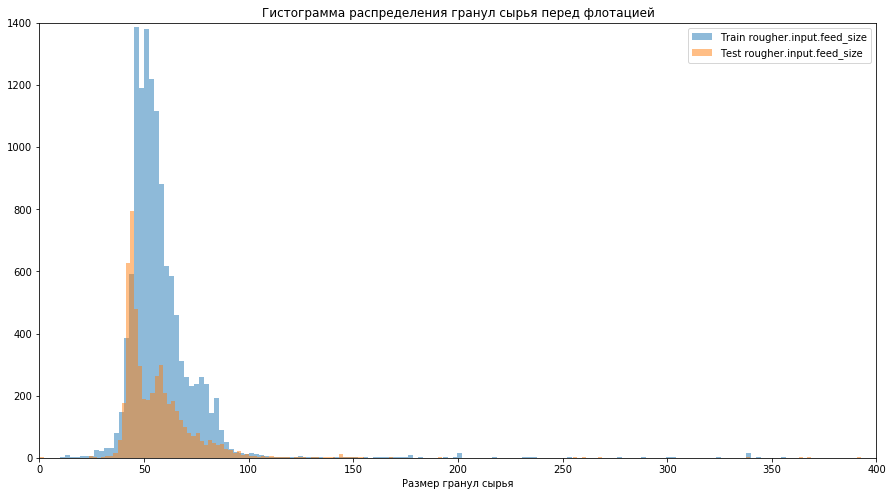

In [27]:
plt.figure(figsize=[15,8])

plt.hist(train['rougher.input.feed_size'], bins=200, label = 'Train rougher.input.feed_size', alpha=.5)
plt.hist(test['rougher.input.feed_size'], bins=200, label = 'Test rougher.input.feed_size', alpha=.5)

plt.xlim([0, 400])
plt.ylim([0, 1400])

plt.xlabel("Размер гранул сырья")

plt.legend()

plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

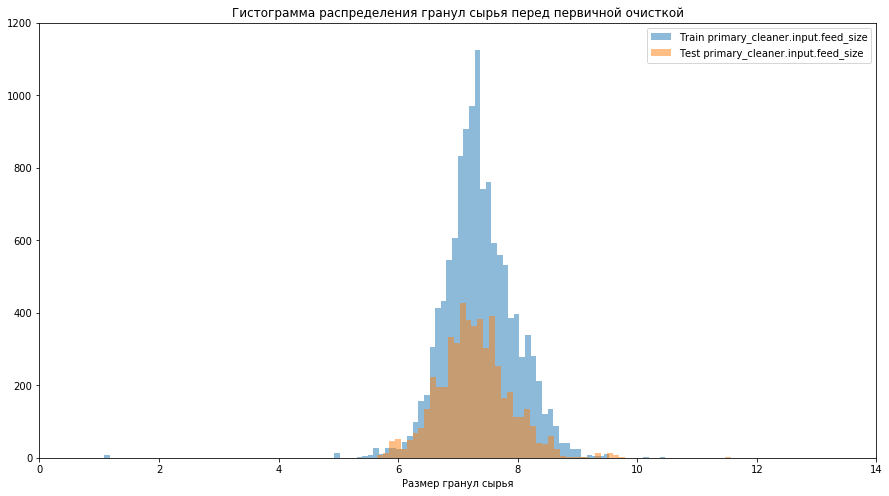

In [28]:
plt.figure(figsize=[15,8])

plt.hist(train['primary_cleaner.input.feed_size'], bins=100, label = 'Train primary_cleaner.input.feed_size', alpha=.5)
plt.hist(test['primary_cleaner.input.feed_size'], bins=100, label = 'Test primary_cleaner.input.feed_size', alpha=.5)

plt.xlim([0, 14])
plt.ylim([0, 1200])

plt.xlabel("Размер гранул сырья")

plt.legend()

plt.title("Гистограмма распределения гранул сырья перед первичной очисткой")
plt.show()

Размеры большинства частиц лежат в одинаковом интервале для обоих выборок.

### Исследую суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [29]:
c_sum = pd.DataFrame({
    'руда' : full[['rougher.input.feed_ag',
          'rougher.input.feed_pb',
          'rougher.input.feed_sol',
          'rougher.input.feed_au']].sum(axis=1),
    'черновой_концентрат': full[['rougher.output.concentrate_ag',
          'rougher.output.concentrate_pb',
          'rougher.output.concentrate_sol',
          'rougher.output.concentrate_au']].sum(axis=1),
    'первичная_очистка': full[['primary_cleaner.output.concentrate_ag',
          'primary_cleaner.output.concentrate_pb',
          'primary_cleaner.output.concentrate_sol',
          'primary_cleaner.output.concentrate_au']].sum(axis=1),
    'финальный_продукт': full[['final.output.concentrate_ag',
          'final.output.concentrate_pb',
          'final.output.concentrate_sol',
          'final.output.concentrate_au']].sum(axis=1)})
c_sum

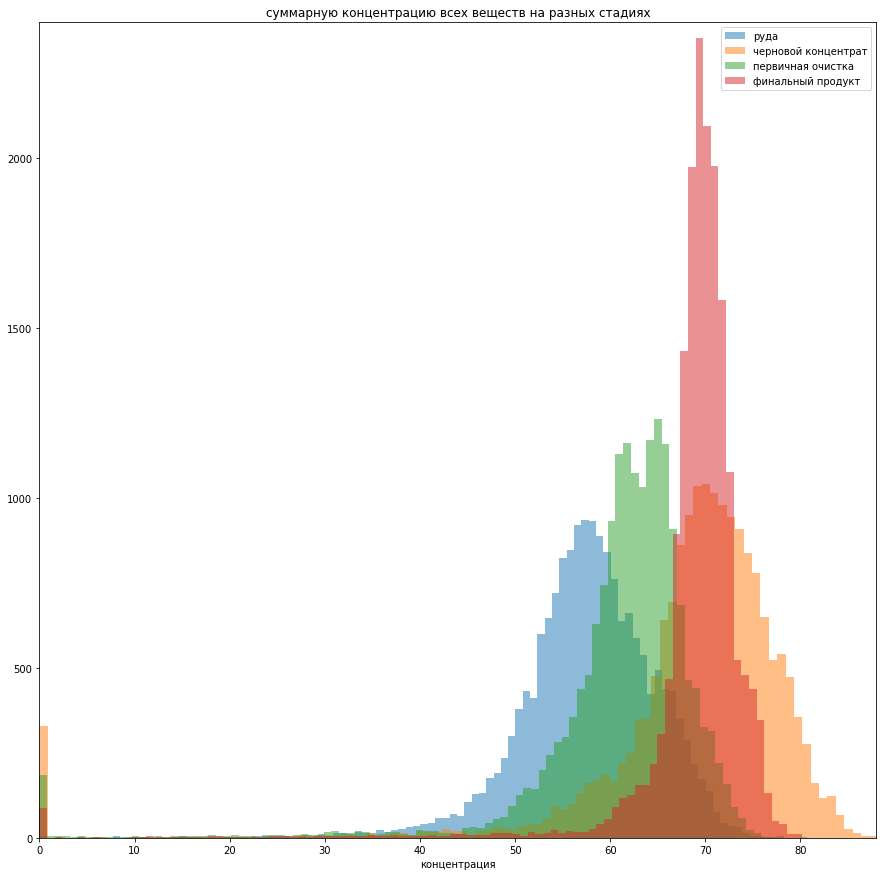

In [30]:
plt.figure(figsize=[15,15])

plt.hist(c_sum['руда'], bins=100, label = 'руда', alpha=.5)
plt.hist(c_sum['черновой_концентрат'], bins=100, label = 'черновой концентрат', alpha=.5)
plt.hist(c_sum['первичная_очистка'], bins=100, label = 'первичная очистка', alpha=.5)
plt.hist(c_sum['финальный_продукт'], bins=100, label = 'финальный продукт', alpha=.5)

plt.xlim([0, 88])
plt.ylim([0, 2400])

plt.xlabel("концентрация")

plt.legend()

plt.title("суммарную концентрацию всех веществ на разных стадиях")
plt.show()

Видны выбросы в районе нуля, рассмотрю эти графики по одному:

In [31]:
fig = px.histogram(c_sum, x='руда', marginal='box', template='seaborn',
    title='суммарная концентрация металлов и солей в золотоносной руде')
fig.show()

In [32]:
fig = px.histogram(c_sum, x='черновой_концентрат', marginal='box', template='seaborn',
    title='суммарная концентрация металлов и солей в черновом концентрате')
fig.show()

In [33]:
fig = px.histogram(c_sum, x='первичная_очистка', marginal='box', template='seaborn',
    title='суммарная концентрация металлов и солей после первичной очистки')
fig.show()

In [34]:
fig = px.histogram(c_sum, x='финальный_продукт', marginal='box', template='seaborn',
    title='суммарная концентрация металлов и солей в финальном продукте')
fig.show()

Большое количество нулей суммарной концентрации на стадиях чернового концентрата, первичной очистки, финального продукта. Эти значения скорее всего являются техническим сбоем, избавлюсь от них.

In [35]:
zeros = c_sum.query('финальный_продукт==0 or первичная_очистка==0 or черновой_концентрат==0').index
def drop_with_info(df, index):
    len_df = len(df)
    df = df.drop(index=index, errors='ignore')
    print('Процент уделенных строк в датафрейме', "{:.2%}".format((len_df - len(df)) / len_df))
    return df
print('Исходные данные')
full = drop_with_info(full, zeros)
    

Исходные данные
Процент уделенных строк в датафрейме 2.82%


In [36]:
print('Oбучающая выборка')
train = drop_with_info(train, zeros)

Oбучающая выборка
Процент уделенных строк в датафрейме 2.69%


In [37]:
print('тестовая выборка')
test = drop_with_info(test, zeros)

тестовая выборка
Процент уделенных строк в датафрейме 3.14%


### Корреляция признаков

Изучу корреляцию признаков, которые используются в тестовой выборке, а значит будут использоваться для обучения модели

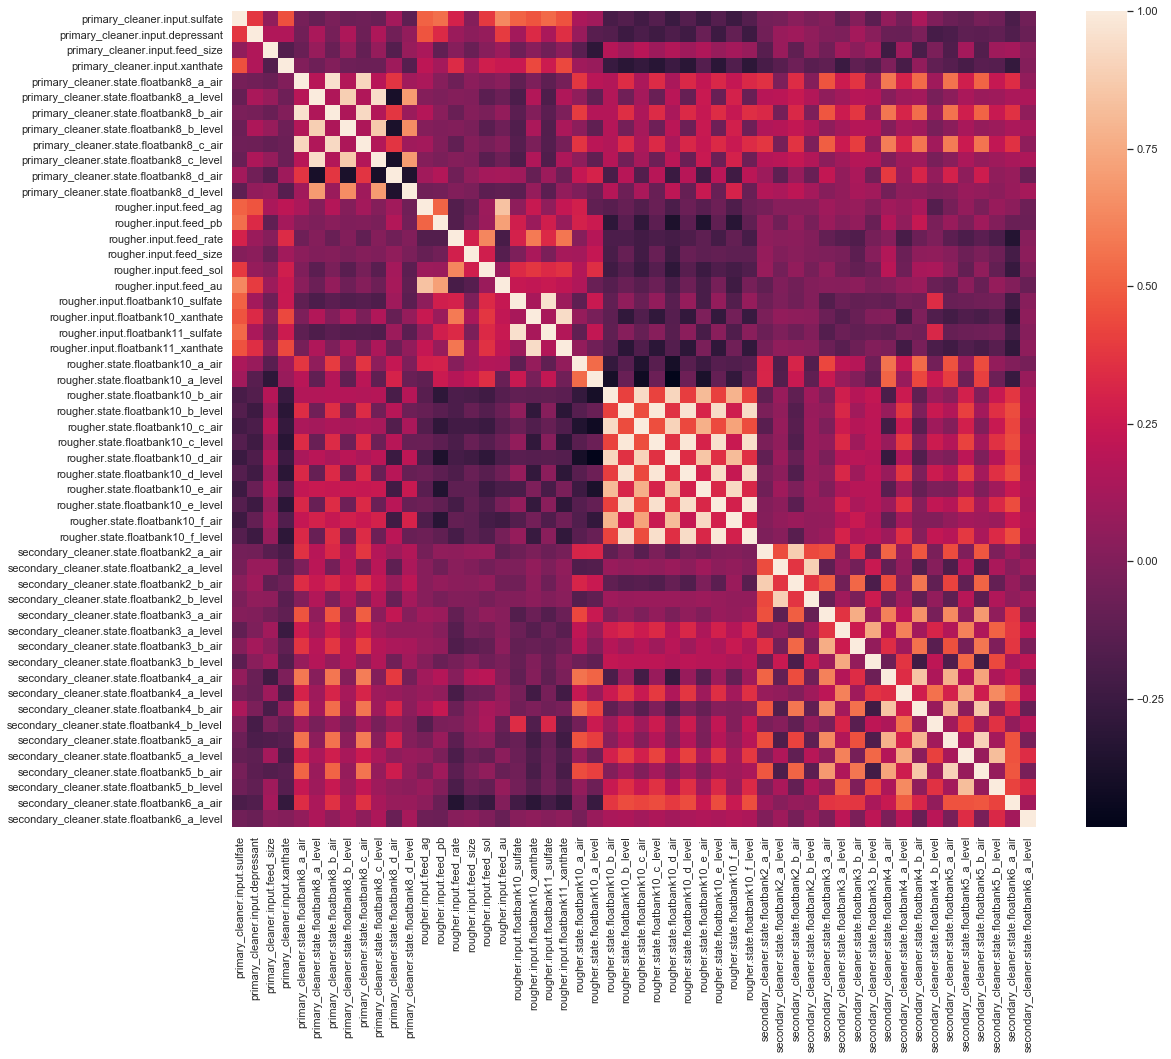

In [38]:
sns.set(rc = {'figure.figsize':(18,15)})
sns.heatmap(full[test.columns].corr())

большое количество призноков имеют сильную корреляцию. Получу список столбцов с высокой корреляцией

In [39]:
strong_correlation = (
    full[test.columns].corr().abs()                                        
    .pipe(lambda x: x[(.8 < x) & (x < 1)])        
    .unstack().dropna().drop_duplicates()
)  

strong_correlation

primary_cleaner.state.floatbank8_a_air      primary_cleaner.state.floatbank8_b_air        0.958172
                                            primary_cleaner.state.floatbank8_c_air        0.916945
primary_cleaner.state.floatbank8_a_level    primary_cleaner.state.floatbank8_b_level      0.885955
                                            primary_cleaner.state.floatbank8_c_level      0.943855
primary_cleaner.state.floatbank8_b_air      primary_cleaner.state.floatbank8_c_air        0.928259
primary_cleaner.state.floatbank8_b_level    primary_cleaner.state.floatbank8_c_level      0.869272
rougher.input.feed_ag                       rougher.input.feed_au                         0.840375
rougher.input.floatbank10_sulfate           rougher.input.floatbank11_sulfate             0.955539
rougher.input.floatbank10_xanthate          rougher.input.floatbank11_xanthate            0.939508
rougher.state.floatbank10_b_air             rougher.state.floatbank10_c_air               0.931922
          

In [40]:
strong_correlation_drop = strong_correlation.index.get_level_values(0).drop_duplicates()
strong_correlation_drop

Index(['primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level', 'rougher.input.feed_ag',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level'],
      dtype='object')

## Модель

### Признаки и целевые признаки

Для обучающей выборки избавлюсь от столбцов, которых нет в тренировочной. Из обеих выборок удалю столбцы с высокой корреляцией. На этапе флотации не все данные доступны для предсказания, опеделю для этого этапа соответвующие столбцы.
Целевые признаки для тренировочной выборки запишу из исходных двнных, по индексу. 

In [41]:
features_final_train = train[test.columns].drop(columns=strong_correlation_drop)#обучающая выбока
                                                                                #для предсказания final.output.recovery
features_final_test = test.drop(columns=strong_correlation_drop)#тестовая выбока для предсказания final.output.recovery

rougher = list(s for s in features_final_train.columns if "rougher" in s)#столбцы значения которых известны нам на этапе флотации

features_rougher_train = features_final_train[rougher]#обучающая выбока для предсказания rougher.output.recovery
features_rougher_test = features_final_test[rougher]#тестовая выбока для предсказания rougher.output.recovery

target_rougher_train = train['rougher.output.recovery']
target_final_train = train['final.output.recovery'] 

target_rougher_test = full.loc[test.index]['rougher.output.recovery']
target_final_test = full.loc[test.index]['final.output.recovery']

In [42]:
print('Признаки:')
print()
print('Обучающая выборка для этапа очиски', features_final_train.shape)
print('Тестовая выборка для этапа очиски', features_final_test.shape)
print()
print('Обучающая выборка для этапа флотации', features_rougher_train.shape)
print('Тестовая выборка для этапа флотации', features_rougher_test.shape)
print()
print('Целевые признаки:')
print('Обучение', target_rougher_train.shape, target_final_train.shape)
print('Тест', target_rougher_test.shape, target_final_test.shape)

Признаки:

Обучающая выборка для этапа очиски (12091, 31)
Тестовая выборка для этапа очиски (5082, 31)

Обучающая выборка для этапа флотации (12091, 11)
Тестовая выборка для этапа флотации (5082, 11)

Целевые признаки:
Обучение (12091,) (12091,)
Тест (5082,) (5082,)


### Метрика качества

Для решения задачи использую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
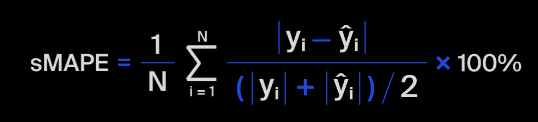



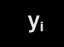 
Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.


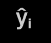
Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

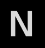
Количество объектов в выборке.


In [43]:
def smape(target, predicted):
    return (
        (abs(target - predicted) / ((abs(target) + abs(predicted)) / 2)).mean()* 100 
    )    

Из функции создам метрику для последующей кросс-валидации:

In [44]:
score = make_scorer(smape, greater_is_better=False)

### Выбор модели. Флотация

#### Линейная регрессия

In [45]:
def lin_reg(features, target):   
    model = LinearRegression()
    cv_results = cross_validate(model, features, target, scoring=score, cv=5)
    print('sMAPE для модели линейной регрессии: {0:.3}'.format(abs(cv_results['test_score'].mean())) + '%')
    
lin_reg(features_rougher_train, target_rougher_train)

sMAPE для модели линейной регрессии: 6.52%


#### Решающее дерево

In [46]:

best_depth = 0
sMAPE_best = 0

for depth in range(1,10):
    model = DecisionTreeRegressor(random_state=123456, max_depth=depth)
    cv_results = cross_validate(model, features_rougher_train, target_rougher_train, scoring=score, cv=5)
    sMAPE = abs(cv_results['test_score'].mean())
    if sMAPE < sMAPE_best or depth==1:
        best_depth = depth
        sMAPE_best = sMAPE


print('Лучшая глубина дерева', best_depth)
print('sMAPE для модели решающего дерева: {0:.3}'.format(sMAPE_best) + '%')
   


Лучшая глубина дерева 4
sMAPE для модели решающего дерева: 6.58%


#### Случайный лес

In [47]:
best_depth = 0
sMAPE_best = 0
best_estim = 0

for estim in range(1,15):
    for depth in range(1,20):
        model = RandomForestRegressor(random_state=123456,  n_estimators=estim, max_depth=depth)
        cv_results = cross_validate(model, features_rougher_train, target_rougher_train, scoring=score, cv=5)
        sMAPE = abs(cv_results['test_score'].mean())
        if sMAPE < sMAPE_best or estim==1:
            best_depth = depth
            sMAPE_best = sMAPE
            best_estim = estim


print('Лучшая глубина дерева', best_depth)
print('Лучшее количество деревьев', best_estim)
print('sMAPE для модели решающего дерева: {0:.3}'.format(sMAPE_best) + '%')

Лучшая глубина дерева 9
Лучшее количество деревьев 14
sMAPE для модели решающего дерева: 6.29%


Лучше всего на этапе флотации показала себя модель случайного леса.

### Выбор модели. Очистка

#### Линейная регрессия

In [48]:
lin_reg(features_final_train, target_final_train)

sMAPE для модели линейной регрессии: 10.9%


#### Решающее дерево

In [49]:

best_depth = 0
sMAPE_best = 0

for depth in range(1,5):
    model = RandomForestRegressor(random_state=123456, max_depth=depth)
    cv_results = cross_validate(model, features_final_train, target_final_train, scoring=score, cv=5)
    sMAPE = abs(cv_results['test_score'].mean())
    if sMAPE < sMAPE_best or depth==1:
        best_depth = depth
        sMAPE_best = sMAPE


print('Лучшая глубина дерева', best_depth)
print('sMAPE для модели решающего дерева: {0:.3}'.format(sMAPE_best) + '%')

Лучшая глубина дерева 3
sMAPE для модели решающего дерева: 9.42%


#### Случайный лес

In [50]:
best_depth = 0
sMAPE_best = 0
best_estim = 0

for estim in range(1,15):
    for depth in range(1,20):
        model = RandomForestRegressor(random_state=123456,  n_estimators=estim, max_depth=depth)
        cv_results = cross_validate(model, features_final_train, target_final_train, scoring=score, cv=5)
        sMAPE = abs(cv_results['test_score'].mean())
        if sMAPE < sMAPE_best or estim==1:
            best_depth = depth
            sMAPE_best = sMAPE
            best_estim = estim


print('Лучшая глубина дерева', best_depth)
print('Лучшее количество деревьев', best_estim)
print('sMAPE для модели решающего дерева: {0:.3}'.format(sMAPE_best) + '%')

Лучшая глубина дерева 3
Лучшее количество деревьев 14
sMAPE для модели решающего дерева: 9.49%


### Тестирование модели

Проведу тестирование моделей с лучшими показателями на тестовых данных. Чтобы оценить адекватность моделей, сравню их с Дамми моделью, с помощью Т-теста, для этого понадобится столбец со значением ошибок, а не среднее.

In [51]:
def sAPE(target_valid, predicted):
    return (
        (abs(target_valid - predicted) / ((abs(target_valid) + abs(predicted)) / 2))* 100 
    )  

In [52]:
def sAPE_calc(model, features_train, target_train, features_test, target_test):
    model.fit(features_train, target_train)
    predicted = model.predict(features_test)
    return sAPE(target_test, predicted)

Итоговая метрика:
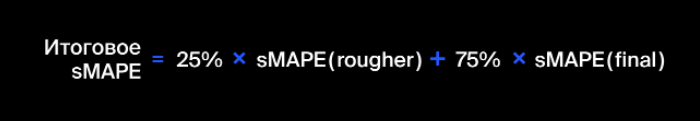

In [53]:
model_rougher = RandomForestRegressor(random_state=123456, max_depth=10, n_estimators=14)

sAPE_rougher = sAPE_calc(
    model_rougher,
    features_rougher_train, target_rougher_train, 
    features_rougher_test, target_rougher_test
)

print('sMAPE модели для флотации на тестовой выборке: {0:.3}'.format(sAPE_rougher.mean()) + '%')

model_final =  RandomForestRegressor(random_state=123456, max_depth=3, n_estimators=14)

sAPE_final = sAPE_calc(
    model_final,
    features_final_train, target_final_train,
    features_final_test, target_final_test
)

print('sMAPE модели для очистки на тестовой выборке: {0:.3}'.format(sAPE_final.mean()) + '%')

sAPE_combined = .25 * sAPE_rougher + .75 * sAPE_final
print('Итоговое sMAPE моделей на тестовой выборке: {0:.3}'.format(sAPE_combined.mean()) + '%')

sMAPE модели для флотации на тестовой выборке: 4.27%
sMAPE модели для очистки на тестовой выборке: 7.66%
Итоговое sMAPE моделей на тестовой выборке: 6.81%


### Адекватность модели

Обучу Дамми модель

In [54]:
dummy_rougher = DummyRegressor(strategy='mean')

sAPE_dummy_rougher = sAPE_calc(
    dummy_rougher,
    features_rougher_train, target_rougher_train,
    features_rougher_test, target_rougher_test
)

print('sMAPE Дамми модели для флотации на тестовой выборке: {0:.3}'.format(sAPE_dummy_rougher.mean()) + '%')

dummy_final = DummyRegressor(strategy='mean')

sAPE_dummy_final = sAPE_calc(
    dummy_final,
    features_final_train, target_final_train,
    features_final_test, target_final_test
)

print('sMAPE Дамми модели для очистки на тестовой выборке: {0:.3}'.format(sAPE_dummy_final.mean()) + '%')

sAPE_dummy_combined = .25 * sAPE_dummy_rougher + .75 * sAPE_dummy_final
print('Итоговое sMAPE Дамми моделей на тестовой выборке: {0:.3}'.format(sAPE_dummy_combined.mean()) + '%')

sMAPE Дамми модели для флотации на тестовой выборке: 5.5%
sMAPE Дамми модели для очистки на тестовой выборке: 8.53%
Итоговое sMAPE Дамми моделей на тестовой выборке: 7.77%


Для подтверждения адекватности обученных ранее моделей, необходимо доказать, что их метрики sMAE, меньше, чем у константной модели.
Нулевая гипотеза - метрики не различаются;
Альтернативная гипотеза - sMAPE у построеных моделей меньше, чем у константных модели.

In [55]:
results = st.ttest_ind(sAPE_combined, sAPE_dummy_combined, equal_var=True)
alpha = 0.05

print('p-значение: ', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (sAPE_combined.mean() < sAPE_dummy_combined.mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.4089027909533477e-12
Отвергаем нулевую гипотезу


### Важность признаков

In [56]:
def feature_importance(model, features_train, features_test, target_test, process_stage=''):
    
    result = permutation_importance(model, features_test, target_test, scoring=score, random_state=123)
    feature_importances = result.importances_mean.tolist()
    feature_names = features_train.columns.tolist()

        # график
    fig = go.Figure(go.Bar(
        x=feature_importances,
        y=feature_names,
        error_x=dict(array=result.importances_std, color='green'),
        orientation='h',
        marker={'color': feature_importances,
                'colorscale': 'bluered'}
    ))
    fig.update_yaxes(categoryorder='total ascending')
    fig.update_layout(
        height=900, width=900,
        title={'text': 'Важность признаков для предсказаний модели ' + process_stage,
                'x':0.5, 'xanchor': 'center'},
    )
    fig.show()

In [69]:
feature_importance(model_rougher, features_rougher_train, features_rougher_test, target_rougher_test, 'на стадии флотации')

In [70]:
feature_importance(model_final, features_final_train, features_final_test, target_final_test, 'на стадии очистки')

Для обоих этапов вторым по важности признаком является rougher.input.feed_au, те концентрация золота в руде. Для стадии флотации самым важным стал параметр - rougher.state.floatbank10_a_level, для предсказания результатов после стадии очиски -  primary_cleaner.input.sulfate.

## Выводы


В ходе работы на проектом изучены данные. Признаки с высокой корреляцией(>|0.8|) найдены и отброшены, чтобы уменьшить дисперсию моделей.

Найдены аномальные нуливые значения в концентрациях металлов и солей, которые можно объяснить техническим сбоем.

Выделены признаки и целевые признаки для стадии флотации и для предсказания финального продукта, после стадии очистки.

Постороены модели линейной регрессии, решающего дерева, случайного леса. Для флотации и этапа очистки проведена кросс-валидация и подбор гиперпараметров, вычислена sMAE.


По результатам кросс валидации были выбраны лучшие модели:

Модель случайного леса с параметром глубины 4 и количеством деревьев 14 для этапа флотации: sMAPE = 6.29%

Модель случайного леса с параметром глубины 3 и количеством деревьев 14 для этапа очистки, : sMAPE = 9.49%

На тестовой выборке:

 - sMAPE модели для флотации на тестовой выборке: 4.27%
 - sMAPE модели для очистки на тестовой выборке: 7.66%
 - Итоговое sMAPE моделей на тестовой выборке: 6.81%

Выполнена проверка адекватности моделей: произведено сравнение их результатов с результатами Дамми модели, которая предсказывает только средние значения для целевого признака:

 - sMAPE Дамми модели для флотации на тестовой выборке: 5.5%
 - sMAPE Дамми модели для очистки на тестовой выборке: 8.53%
 - Итоговое sMAPE Дамми моделей на тестовой выборке: 7.77%
 
Выполнена проверка с помощью t-критерия Стьюдента, различаются ли метрики у нашей и константной моделей. на уровне статистической начимости в 5% принята следующая гипотеза: метрика sMAPE у построеных моделей меньше, чем у константной модели.

Для обоих этапов вторым по важности признаком является rougher.input.feed_au, те концентрация золота в руде. Для стадии флотации самым важным стал параметр - rougher.state.floatbank10_a_level, для предсказания результатов после стадии очиски -  primary_cleaner.input.sulfate.

Можно сделать вывод, что прототип модели построен адекватно: его предсказания лучше, чем у константной модели. Однако разница метрики ошибки не так велика.